# Imports

In [7]:
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
import numpy as np
import pandas as pd
from scipy import stats
warnings.filterwarnings("ignore")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 

# plt.style.use('rose-pine-dawn')

# init MCMC

In [2]:
# MCMC parameters
num_walkers = 16
num_threads = 8 #mp.cpu_count() # or a different number if you prefer

mtot = 5.5
mtot_err = 0.5
plx = 2.654763675820139 # or 2.41 from Menten 2007
plx_err = 0.042361263 # 0.03

my_driver = orbitize.driver.Driver('B2-B3-orbitizetab.csv', # path to data file
                                  'MCMC', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  mtot, # total system mass [M_sun]
                                  plx, # total parallax of system [mas]
                                  mass_err=mtot_err, # mass error [M_sun]
                                  plx_err=plx_err, # parallax error [mas]
                                  mcmc_kwargs={'num_walkers': num_walkers, 'num_threads': num_threads})
epochs = my_driver.system.data_table['epoch']

# Run MCMC

In [3]:
# RUN MCMC
burnpower = 1e5 # total: 4mil
power = 1e5 # total: 4mil
total_orbits = 5*power*num_walkers # number of steps x number of walkers (at lowest temperature)
burn_steps = burnpower # steps to burn in per walker
thin = 2 # only save every 2nd step

my_driver.sampler.run_sampler(int(total_orbits), burn_steps=int(burn_steps), thin=int(thin))

Starting Burn in
100000/100000 steps of burn-in complete
Burn in complete. Sampling posterior now.
500000/500000 steps completed
Run complete


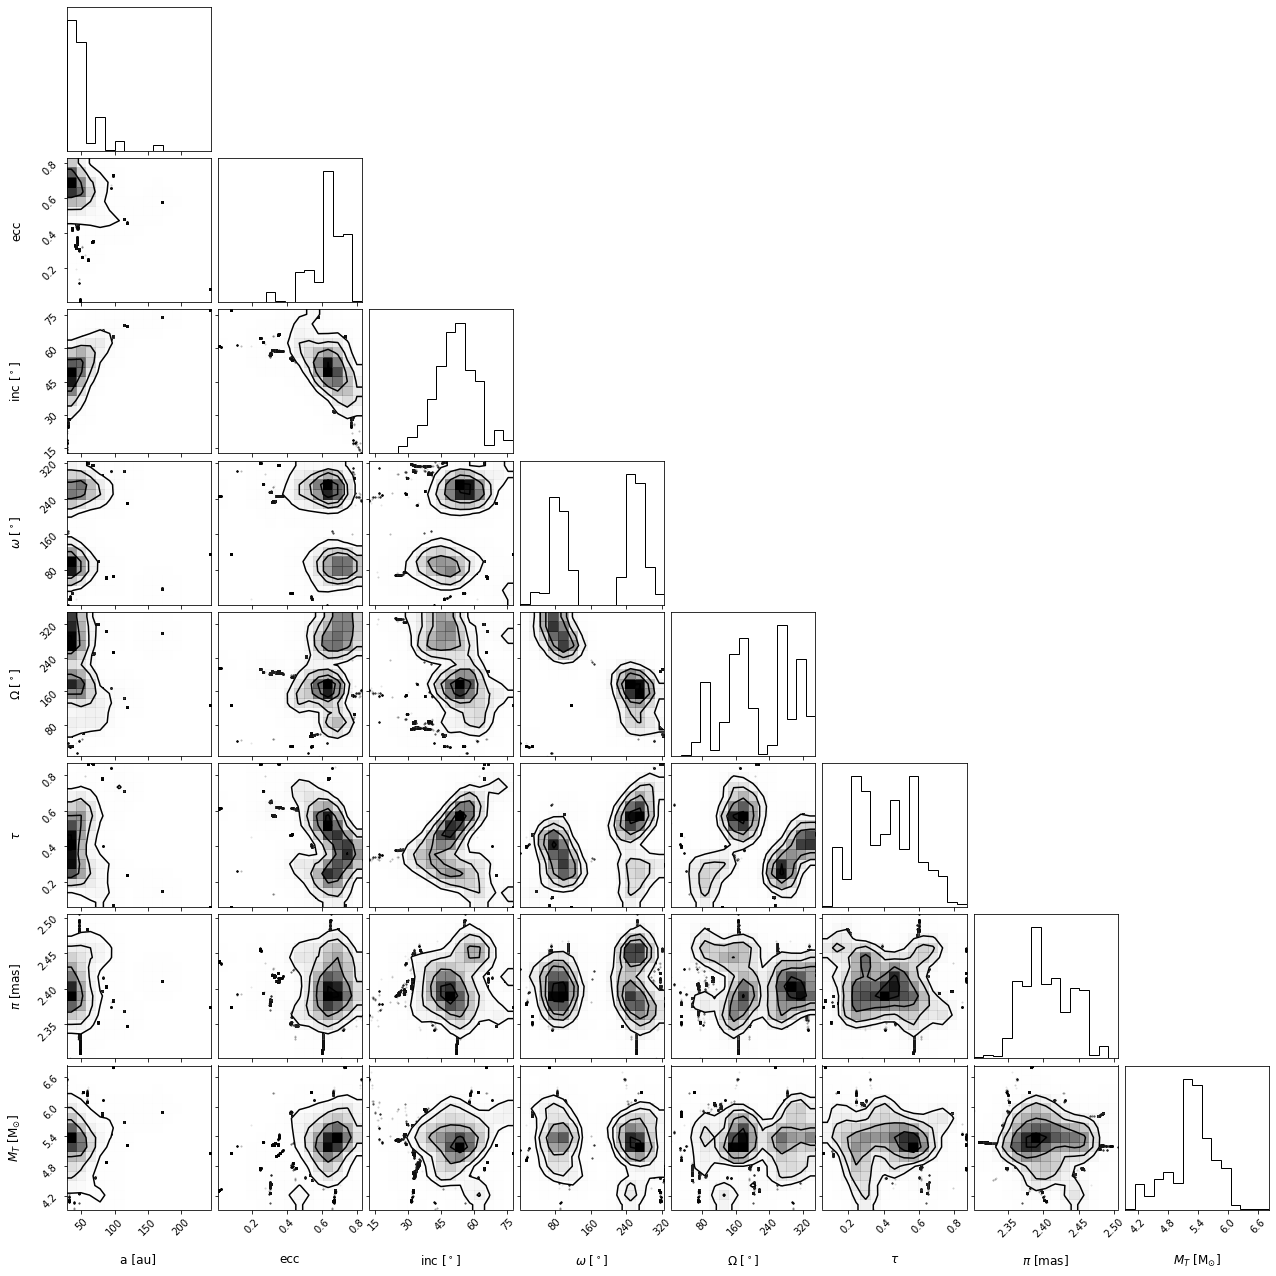

In [16]:
#MCMC PLOTS
corner_plot_fig = my_driver.sampler.results.plot_corner(smooth=1, bins=15) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png') # This is matplotlib.figure.Figure.savefig()

In [ ]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(param_list=['sma1','ecc1'], n_walkers=5)

In [4]:
# save result as hdf5
hdf5_filename='my_posterior.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

# Load Prev

In [3]:
# load in saved hdf5 result
hdf5_filename = 'b2b3_post_updateErr2.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename)

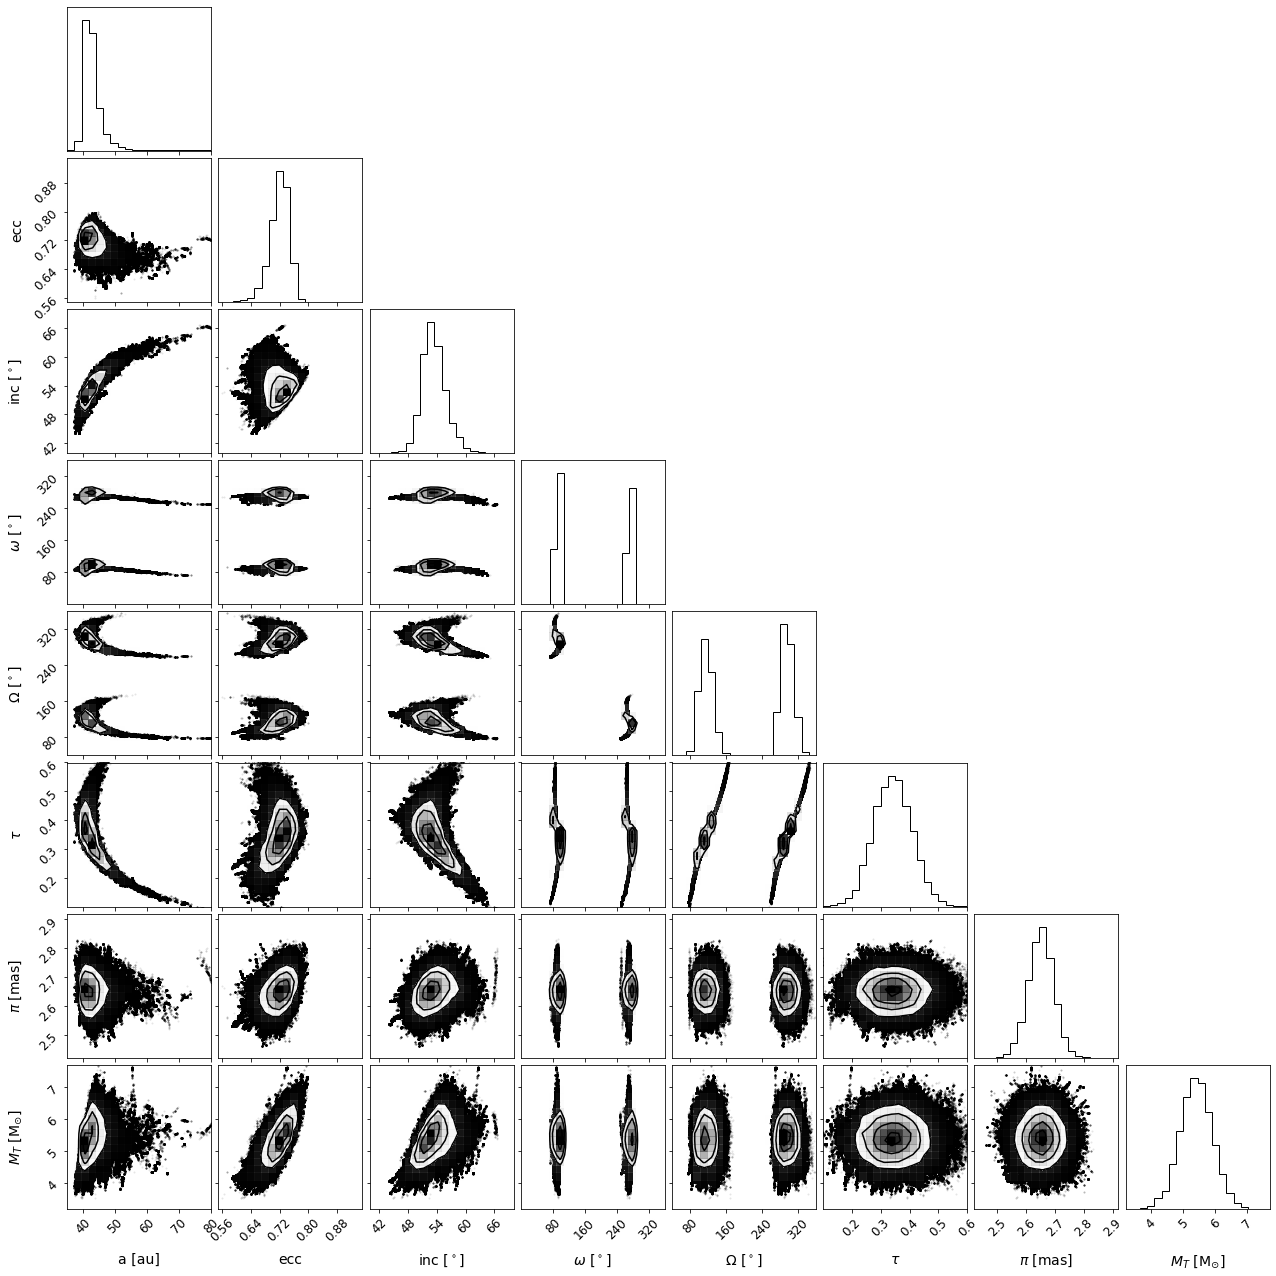

In [9]:
#MCMC PLOTS
range_values = [(35,80),(0.55,0.95),(40,70),(0, 360),(40,360),(0.1,0.6),(2.42,2.92),(3.2,7.7)]
corner_plot_fig = loaded_results.plot_corner(#smooth=2, bins=10
    range=range_values,
) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

In [12]:
results = pd.read_csv(
    'visao_b2-b3 newerr.csv',
    header = 0,
    sep = ',',
    usecols = lambda x:x in ["Date", "med sep", "med PA", "med seperr", "med PAerr", "stdev sep", "stdev PA"],
    nrows = 9
)

for pa_i in range(len(results['med PA'])):
    pa = results['med PA'][pa_i]
    if pa < 90:
        results['med PA'][pa_i] += 180

In [13]:
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['Date']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['med sep']
outtable['sep_err'] = results['med seperr']
outtable['pa'] = results['med PA']
outtable['pa_err'] = results['med PAerr']
outtable.to_csv('visao-b2b3-orbitizelike.csv', index=False)
# outtable.head()

In [14]:
visao_pa_default = -0.59
visao_pa_default_err = 0.3
outtable['pa_default'] = outtable['pa']-0.59
outtable['sep_default'] = outtable['sep']*7.8513
outtable['pa_err_default'] = np.sqrt(((outtable['pa_err'])**2)+((0.3)**2))
outtable['sep_err_default'] = outtable['sep_default']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((0.02/7.8513)**2))
# outtable.head()

# uncorrected plots

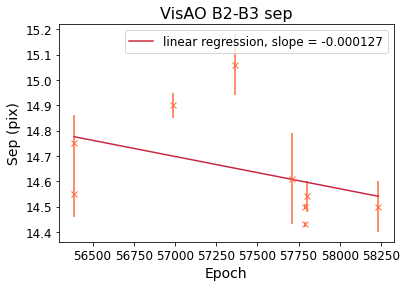

In [15]:
# uncorrected sep in pixels plot
slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['sep'])
plt.errorbar(outtable['epoch'], outtable['sep'], yerr=outtable['sep_err'], ls='none', marker='x', color='#ff6c40')
label = "linear regression, slope = "+str(round(slope,6))
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], color='#c72a40', label=label)
plt.legend()
# plt.xlim(-500, 6700)
plt.title('VisAO B2-B3 sep')
plt.xlabel('Epoch')
plt.ylabel('Sep (pix)')
plt.savefig('visao_sep_pix.png', dpi=300)

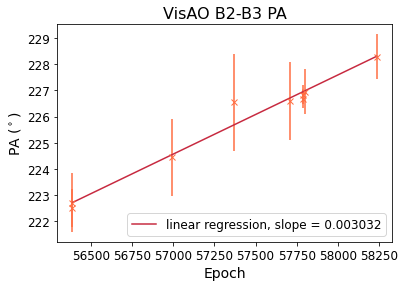

In [16]:
# uncorrected PA 
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa'])
plt.errorbar(outtable['epoch'], outtable['pa'], yerr=outtable['pa_err'], ls='none', marker='x', color='#ff6c40')
label = "linear regression, slope = "+str(round(slope,6))
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], color='#c72a40', label=label)
plt.legend(loc='lower right')
#plt.xlim(-500, 6700)
plt.title('VisAO B2-B3 PA')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa.png', dpi=300)

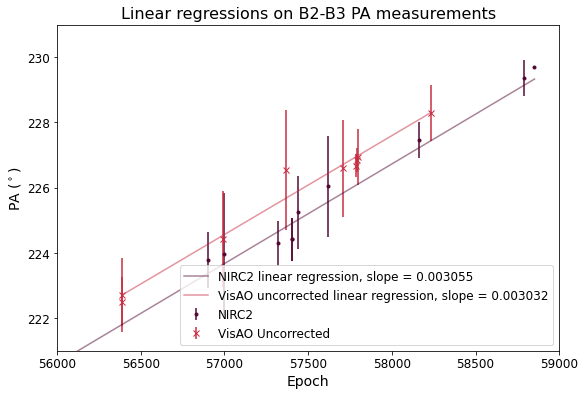

In [17]:
# compare to NIRC2
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

from astropy.time import Time
epochs_yr = Time(outtable['epoch'], format='mjd').decimalyear
epochs_yr_nirc = Time(nircast['epoch'], format='mjd').decimalyear

plt.figure(figsize=(9,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
plt.errorbar(nircast['epoch'], nircast['pa'], yerr=nircast['pa_err'], ls='none', marker='o', markersize=3, label='NIRC2', color='#520833')
label = "NIRC2 linear regression, slope = "+str(round(slope,6))
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], color='#520833', label=label, alpha=0.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa'])
plt.errorbar(outtable['epoch'], outtable['pa'], yerr=outtable['pa_err'], ls='none', marker='x', label='VisAO Uncorrected', color='#c72a40')
label = "VisAO uncorrected linear regression, slope = "+str(round(slope,6))
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], color='#c72a40', label=label, alpha=0.5)

plt.legend(loc='lower right')
plt.xlim(56000, 59000)
plt.ylim(221,231)
plt.title('Linear regressions on B2-B3 PA measurements')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare.png', dpi=300)

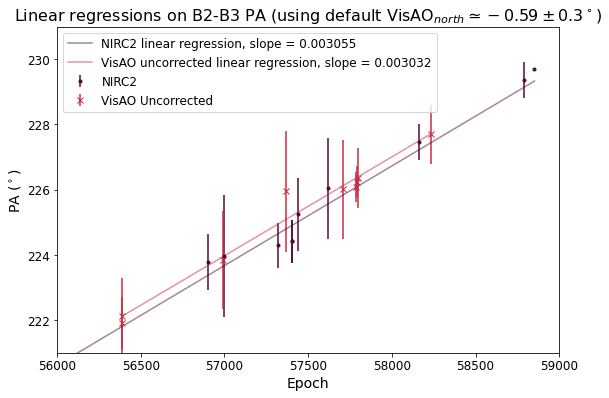

In [18]:
# compare if using default VisAO_north
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

plt.figure(figsize=(9,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
plt.errorbar(nircast['epoch'], nircast['pa'], yerr=nircast['pa_err'], ls='none', marker='o', markersize=3, label='NIRC2', color='#520833')
label = "NIRC2 linear regression, slope = "+str(round(slope,6))
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], color='#520833', label=label, alpha=0.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa_default'])
plt.errorbar(outtable['epoch'], outtable['pa_default'], yerr=outtable['pa_err_default'], ls='none', marker='x', label='VisAO Uncorrected', color='#c72a40')
label = "VisAO uncorrected linear regression, slope = "+str(round(slope,6))
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], color='#c72a40', label=label, alpha=0.5)

plt.legend()
plt.xlim(56000, 59000)
plt.ylim(221,231)
plt.title(r'Linear regressions on B2-B3 PA (using default VisAO$_{north}\simeq-0.59\pm0.3^\circ$)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare_default.png', dpi=300)

In [19]:
# orbitize positions for magao epochs

# semimajor axis 1, eccentricity 1, inclination 1,
# argument of periastron 1, position angle of nodes 1,
# epoch of periastron passage 1
data = loaded_results.post
JDs = outtable['epoch']
sma = data[:, 0]
ecc = data[:, 1]
inc = data[:, 2]
aop = data[:, 3]
pan = data[:, 4]
tau = data[:, 5]
plxs = data[:, 6]
mtots = data[:, 7]
ra, dec, vz = orbitize.kepler.calc_orbit(JDs, sma, ecc, inc, aop, pan, tau, plxs, mtots, tau_ref_epoch=loaded_results.tau_ref_epoch)

In [20]:
# center of orbit distribution
measure_of_tendy = 'mode'

from scipy import stats
seps, pas = orbitize.system.radec2seppa(ra, dec)

exp_seps = np.zeros((seps.shape[0]))
exp_sep_errs = np.zeros((seps.shape[0]))
exp_pas = np.zeros((seps.shape[0]))
exp_pa_errs = np.zeros((seps.shape[0]))
for epoch in range(len(exp_seps)):
    if measure_of_tendy == 'mode':
        sep_ep = stats.mode(seps[epoch])[0][0]
        pa_ep = stats.mode(pas[epoch])[0][0]
    elif measure_of_tendy == 'median':
        sep_ep = np.median(seps[epoch])
        pa_ep = np.median(pas[epoch])
    elif measure_of_tendy == 'mean':
        sep_ep = np.average(seps[epoch])
        pa_ep = np.average(pas[epoch])
    
    sep_ep_Err = np.std(seps[epoch])
    exp_seps[epoch] = sep_ep
    exp_sep_errs[epoch] = sep_ep_Err
    exp_pas[epoch] = pa_ep
    pa_ep_Err = np.std(pas[epoch])
    exp_pa_errs[epoch] = pa_ep_Err

In [21]:
# create dataframes for orbitize positions on magao epochs
pa = outtable['pa']; pa_err = outtable['pa_err']

visP = pa
visPe = pa_err

kekS = exp_seps
kekSe = exp_sep_errs
kekP = exp_pas
kekPe = exp_pa_errs

kekDF = pd.DataFrame(columns=['epoch', 'sep', 'seperr', 'pa', 'paerr'])
kekDF['epoch'] = epochs_yr
kekDF['sep'] = kekS
kekDF['seperr'] = kekSe
kekDF['pa'] = kekP
kekDF['paerr'] = kekPe
kekDF.head()

,epoch,sep,seperr,pa,paerr
0,2013.260274,115.841018,0.039840,221.997037,0.041316
1,2013.263014,115.840664,0.039838,222.000269,0.041317
2,2014.909589,115.598521,0.037164,223.946729,0.044867
3,2015.942466,115.415599,0.033962,225.172276,0.049491
4,2016.877049,115.227843,0.030501,226.287628,0.054866


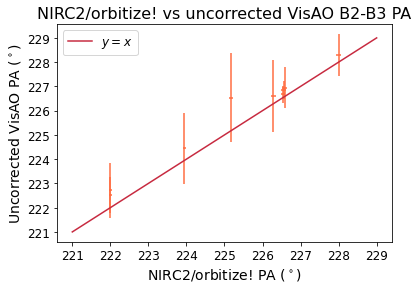

In [22]:
plt.errorbar(x=kekP, y=visP, xerr=kekPe, yerr=visPe, ls='none', color='#ff6c40')
plt.plot([221,229],[221,229], label=r'$y=x$', color='#c72a40')
plt.title('NIRC2/orbitize! vs uncorrected VisAO B2-B3 PA')
plt.legend()
plt.xlabel(r'NIRC2/orbitize! PA ($^\circ$)')
plt.ylabel(r'Uncorrected VisAO PA ($^\circ$)')
plt.savefig('visao_pa_compare_uncorrected.png', dpi=300)

# minimize residuals to orbitize fit

0.497 0.19175679450885924


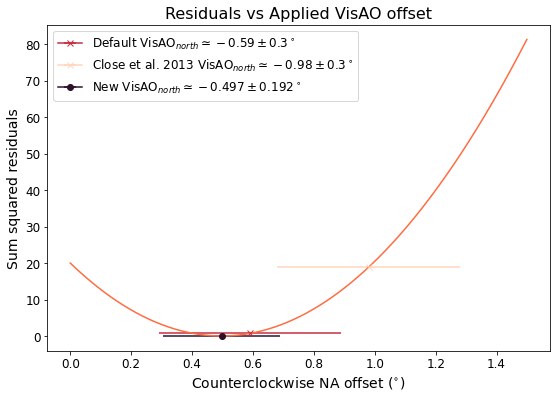

In [23]:
import numpy as np
from scipy.odr import *
residuals = []
for i in np.arange(0.0, 1.5, 0.001):
    visP_new = visP-i
    residP = visP_new - kekP
    Perr = np.sqrt((visPe)**2+(kekPe)**2)
    # sum squared residuals
    sumsquare = np.sum(residP)**2    
    # error on i
    from statsmodels.stats.weightstats import DescrStatsW
    wstats = DescrStatsW(residP, 1/((Perr)**2), ddof=0)
    best_fit_err = wstats.std

    residuals.append((i, sumsquare, best_fit_err))    
        
pa_resid_arr = np.array(residuals)
best_pa_off = pa_resid_arr[pa_resid_arr[:,1] == pa_resid_arr[:,1].min()]
print(best_pa_off[0][0], best_pa_off[0][2])
pa_resid_arr[:,0] = [round(x, 3) for x in pa_resid_arr[:,0]]
orig_pa_off = pa_resid_arr[pa_resid_arr[:,0] == 0.590]
close_pa_off = pa_resid_arr[pa_resid_arr[:,0] == 0.980]
plt.figure(figsize=(9,6))
plt.plot(pa_resid_arr[:,0], pa_resid_arr[:,1], color='#ff6c40')
plt.errorbar(orig_pa_off[:,0][0], orig_pa_off[:,1][0], xerr=visao_pa_default_err, marker='x', label='Default VisAO$_{north}\simeq-0.59\pm0.3^\circ$', color='#c72a40')
# add in Close 2013 too (?)
plt.errorbar(close_pa_off[:,0][0], close_pa_off[:,1][0], xerr=0.3, marker='x', label='Close et al. 2013 VisAO$_{north}\simeq-0.98\pm0.3^\circ$', color='#ffd6bf')
newlabel = 'New VisAO$_{north}\simeq-'+str(round(best_pa_off[0][0],3))+'\pm'+str(round(best_pa_off[0][2],3))+'^\circ$'
plt.errorbar(best_pa_off[:,0][0], best_pa_off[:,1][0], xerr=best_fit_err, marker='o', label=newlabel, color='#2c112b')
plt.title('Residuals vs Applied VisAO offset')#, fontsize=22)
plt.legend()
plt.xlabel(r'Counterclockwise NA offset ($^{\circ}$)')#, fontsize=18)
plt.ylabel('Sum squared residuals')#, fontsize=18)
plt.savefig('NAoff_resids.png', dpi=300)
# plt.vlines(best_pa_off[:,0], ymin=1.5, ymax=2.5)

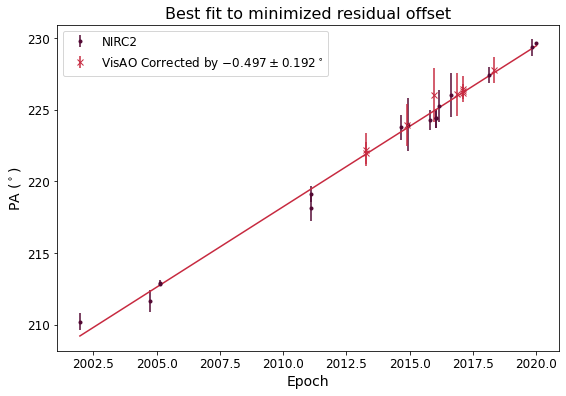

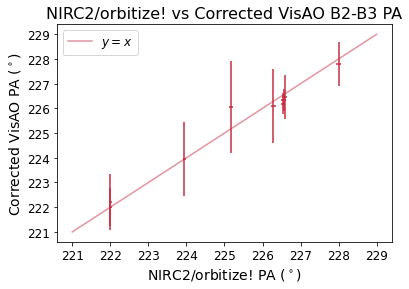

In [24]:
for i in [best_pa_off[0][0]]:
    visP_new = visP-i
    kekP_orig = nircast['pa']
    kekPe_orig = nircast['pa_err']
    allP = np.append(visP_new, kekP_orig)
    allerr = np.append(visPe, kekPe_orig)
    allyr = np.append(epochs_yr, epochs_yr_nirc)
    
    # linear regression accounting for errorbars on y
    x = allyr
    y = allP
    y_err = allerr
    
    # Define a function to fit the data with.
    def lin_func(p, x):
        m, b = p
        return m*x + b

    # Create a model for fitting.
    lin_model = Model(lin_func)

    # Create a RealData object using our initiated data from above.
    data = RealData(x, y, sy=y_err)

    # Set up ODR with the model and data.
    odr = ODR(data, lin_model, beta0=[0., 1.])

    # Run the regression.
    out = odr.run()
        
    x_fit = np.linspace(x.min(), x.max(), 1000)
    y_fit = lin_func(out.beta, x_fit)
    points_y_fit = lin_func(out.beta, epochs_yr)
    visresid = visP_new-points_y_fit
    from statsmodels.stats.weightstats import DescrStatsW
    wstats = DescrStatsW(visresid, 1/visPe, ddof=0)
    best_fit_err = wstats.std
#         print(str(0.497), best_fit_err)
    visPe_new = np.sqrt((visPe)**2+(best_fit_err)**2)
    plt.figure(figsize=(9,6))
    plt.errorbar(epochs_yr_nirc, nircast['pa'], yerr=nircast['pa_err'], linestyle='None', marker='o', color='#520833', markersize=3, label='NIRC2')
    label = r'VisAO Corrected by $-'+str(round(best_pa_off[0][0],3))+'\pm'+str(round(best_pa_off[0][2],3))+'^\circ$'
    plt.errorbar(epochs_yr, visP_new, yerr=visPe_new, linestyle='None', marker='x', color='#c72a40', label=label)
    plt.plot(x_fit, y_fit, color='#c72a40')
    plt.title('Best fit to minimized residual offset')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(r'PA ($^\circ$)')
    plt.savefig('quick_min_resid_fit.png', dpi=300)
    plt.show()
    # 
    plt.figure()
    plt.errorbar(x=kekP, y=visP_new, xerr=kekPe, yerr=visPe_new, ls='none', color='#c72a40')
    plt.plot([221,229],[221,229], label=r'$y=x$', color='#c72a40', alpha=0.5)
    plt.title('NIRC2/orbitize! vs Corrected VisAO B2-B3 PA')
    plt.legend()
    plt.xlabel(r'NIRC2/orbitize! PA ($^\circ$)')
    plt.ylabel(r'Corrected VisAO PA ($^\circ$)')
    plt.savefig('visao_pa_compare_corrected.png', dpi=300)

In [25]:
# for mult/div fractional uncertainties add in quad
# for add/sub uncertainties add in quad
# least squares min on each point 
outtable['platescale'] = kekS/outtable['sep']
outtable['platescale_err'] = outtable['platescale']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((kekSe/kekS)**2))
outtable['plateweight'] = 1/(outtable['platescale_err']**2)

outtable['pa_offset'] = outtable['pa']-kekP
outtable['pa_offset_err'] = np.sqrt(((outtable['pa_err'])**2)+((kekPe)**2))

In [26]:
outtable['pa_expected'] = outtable['pa']-outtable['pa_offset']
outtable['sep_expected'] = outtable['sep']*outtable['platescale']
outtable['pa_err_expected'] = np.sqrt(((outtable['pa_err'])**2)+((outtable['pa_offset_err'])**2))
outtable['sep_err_expected'] = outtable['sep_expected']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((outtable['platescale_err']/outtable['platescale'])**2))
outtable.to_clipboard()

# calc new default

In [43]:
outtable['pa_newdef'] = outtable['pa']-best_pa_off[:,0][0]

newplate = np.average(outtable['platescale'], weights=outtable['plateweight'])
newplate_err = np.std(outtable['platescale'])#1/np.sqrt(np.sum(outtable['plateweight']))
print('new platescale is: '+str(newplate)+'+/-'+str(newplate_err))
newpa = -best_pa_off[0][0]
newpaerr = round(best_pa_off[0][2],3)
print('new pa-off is: '+str(newpa)+'+/-'+str(newpaerr))

outtable['sep_newdef'] = outtable['sep']*newplate
outtable['pa_err_newdef'] = np.sqrt(((outtable['pa_err'])**2)+((best_fit_err)**2))
outtable['sep_err_newdef'] = outtable['sep_newdef']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((newplate_err/newplate)**2))

new platescale is: 7.954976669665251+/-0.0983149475527802
new pa-off is: -0.497+/-0.192


# Orbitize Plots

<Figure size 1008x432 with 0 Axes>

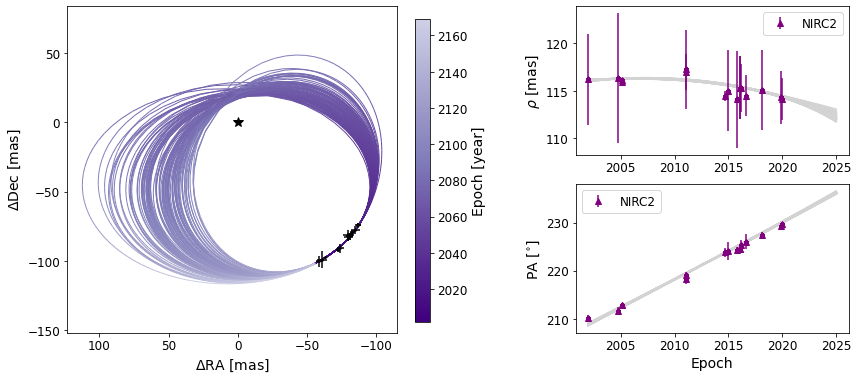

In [30]:
# nirc2 fit 
epochs = my_driver.system.data_table['epoch']
orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=True,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes

# grab data from Driver object
data_tab = my_driver.system.data_table

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# # add expected pos to RA+dec panel
# nirc2ra, nirc2dec = orbitize.system.seppa2radec(nircast['sep'], nircast['pa'])
# ax_orb.errorbar(
#     nirc2ra, nirc2dec, fmt='*', zorder=3, color='cyan', linestyle='', markersize=3
# )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# ax_orb.set_xlim(200,-200)
# ax_orb.set_ylim(-200,200)

orb_fig.savefig('b2b3_orbit_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

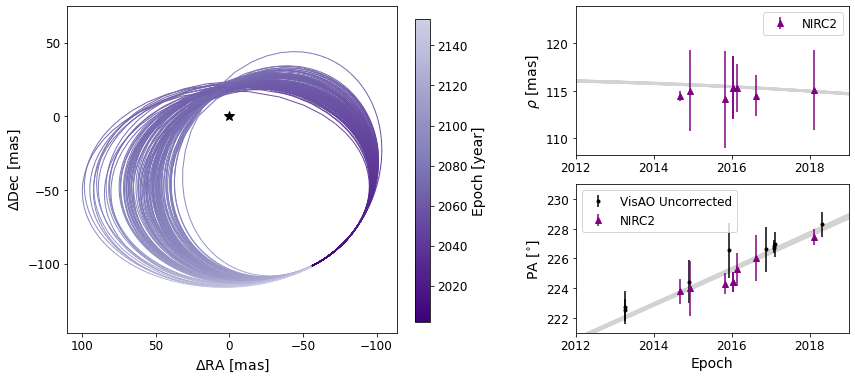

In [31]:
# uncorrected PA
epochs = my_driver.system.data_table['epoch']

orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes



# grab data from Driver object
data_tab = my_driver.system.data_table

# # add data to sep panel
# ax_sep.errorbar(
#     epochs_yr, visS, visSe,
#     color='black', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
# )

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, visP, visPe,
    color='black', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
)

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2019)
ax_pa.set_xlim(2012,2019)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(221,231)

# Save just the portion _inside_ the second axis's boundaries
extent = ax_pa.get_window_extent().transformed(orb_fig.dpi_scale_trans.inverted())
# Pad the saved area by 10% in the x-direction and 20% in the y-direction
orb_fig.savefig('pa_figure_expanded.png', bbox_inches=extent.expanded(1.4, 1.5), dpi=300)

# orb_fig.savefig('b2b3_uncorrected.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

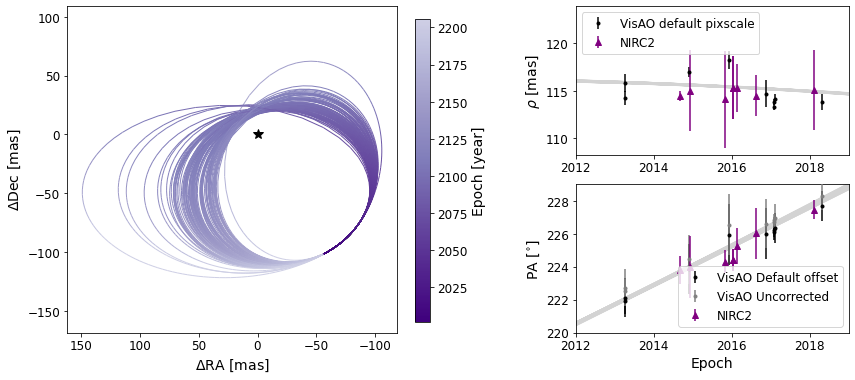

In [32]:
# visao default
orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes

from astropy.time import Time

# grab data from Driver object
data_tab = my_driver.system.data_table

epochs_yr = Time(outtable['epoch'], format='mjd').decimalyear

# add data to sep panel
ax_sep.errorbar(
    epochs_yr, outtable['sep_default'], outtable['sep_err_default'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='VisAO default pixscale'
)

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, outtable['pa_default'], outtable['pa_err_default'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='VisAO Default offset'
)

# add uncorrected data to PA panel
ax_pa.errorbar(
    epochs_yr, visP, visPe,
    color='grey', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
)

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend(loc='upper left')
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2019)
ax_pa.set_xlim(2012,2019)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(220,229)

# Save just the portion _inside_ the second axis's boundaries
extent = ax_pa.get_window_extent().transformed(orb_fig.dpi_scale_trans.inverted())
# Pad the saved area by 10% in the x-direction and 20% in the y-direction
orb_fig.savefig('b2b3_visao_default.png', bbox_inches=extent.expanded(1.4, 5), dpi=300)

# orb_fig.savefig('b2b3_visao_default.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

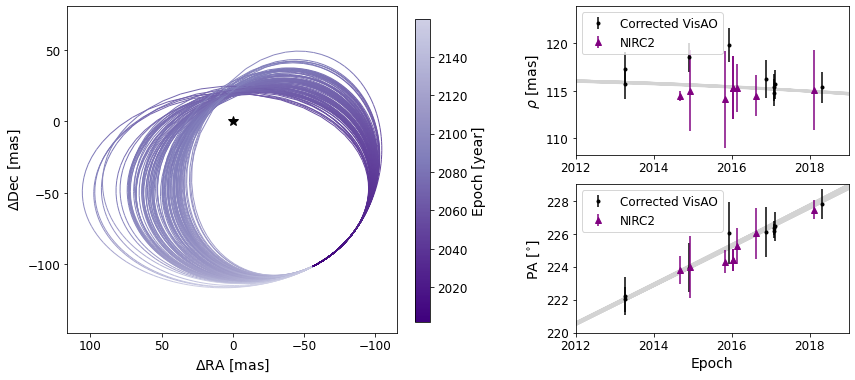

In [33]:
# visao new default
epochs = my_driver.system.data_table['epoch']

orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes

from astropy.time import Time

# grab data from Driver object
data_tab = my_driver.system.data_table

epochs_yr = Time(outtable['epoch'], format='mjd').decimalyear

# add data to sep panel
ax_sep.errorbar(
    epochs_yr, outtable['sep_newdef'], outtable['sep_err_newdef'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='Corrected VisAO'
)

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, outtable['pa_newdef'], outtable['pa_err_newdef'],
    color='black', linestyle='', fmt='o', markersize=3, zorder=3, label='Corrected VisAO'
)

# # add uncorrected data to PA panel
# ax_pa.errorbar(
#     epochs_yr, visP, visPe,
#     color='grey', linestyle='', fmt='o', zorder=3, label='VisAO Uncorrected', markersize=3
# )

# add expected pos to sep panel
ax_sep.errorbar(
    epochs_yr_nirc, nircast['sep'], nircast['sep_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

# add expected pos to PA panel
ax_pa.errorbar(
    epochs_yr_nirc, nircast['pa'], nircast['pa_err'],
    color='purple', linestyle='', fmt='^', zorder=3, label='NIRC2'
)

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend(loc='upper left')
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2019)
ax_pa.set_xlim(2012,2019)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(220,229)

# Save just the portion _inside_ the second axis's boundaries
extent = ax_pa.get_window_extent().transformed(orb_fig.dpi_scale_trans.inverted())
# Pad the saved area by 10% in the x-direction and 20% in the y-direction
orb_fig.savefig('b2b3_visao_corrected.png', bbox_inches=extent.expanded(1.4, 5), dpi=300)

# orb_fig.savefig('b2b3_corrected.png', dpi=300) # This is matplotlib.figure.Figure.savefig()


# Platescale calc and figures

In [39]:
# newpa = 0.41
# newpa_err = 0.11
# newplate = 7.91
# newplate_err = 0.11
# outtable['pa_newdef'] = outtable['pa']-newpa
# outtable['sep_newdef'] = outtable['sep']*newplate
# outtable['pa_err_newdef'] = np.sqrt(((outtable['pa_err'])**2)+((newpa_err)**2))
# outtable['sep_err_newdef'] = outtable['sep_newdef']*np.sqrt(((outtable['sep_err']/outtable['sep'])**2)+((newplate_err/newplate)**2))

In [34]:
outtable['yr'] = epochs_yr

In [35]:
indivresults = pd.read_csv('VisAO B2-B3 HPF Final.csv')
indivresults.head()

,sep,seperr,PA,PAerr,date,filter
0,14.897,0.222,42.298,2.419,2013-04-06,Ys
1,14.755,0.246,43.188,2.586,2013-04-06,Ys
2,14.693,0.192,42.868,2.049,2013-04-06,Ys
3,14.653,0.239,42.535,2.073,2013-04-06,zprime
4,14.558,0.254,42.263,2.364,2013-04-07,rprime


In [36]:
haindiv = indivresults[indivresults['filter']=='SDI-H-alpha']
zindiv = indivresults[indivresults['filter']=='zprime']
yindiv = indivresults[indivresults['filter']=='Ys']
iindiv = indivresults[indivresults['filter']=='iprime']
rindiv = indivresults[indivresults['filter']=='rprime']

In [37]:
timedict = {'2013-04-06':56388,
'2013-04-07':56389,
'2014-11-29':56990,
'2015-12-11':57367,
'2016-11-17':57709,
'2017-02-04':57788,
'2017-02-06':57790,
'2017-02-14':57798,
'2018-04-26':58234}

In [38]:
filters = [haindiv, rindiv, iindiv, yindiv, zindiv]
for filt in filters:
    filt['epoch'] = [timedict[x] for x in filt['date']]

In [39]:
filtdict = {}
filterlist = ['Ha', 'rprime', 'iprime', 'Ys', 'zprime']
i = 0
for filt in filters:
    dates = []
    for day in filt['epoch']:
        if day not in dates:
            dates.append(day)
    datedict = {}
    for date in dates:
        datetab = filt[filt['epoch'] == date]
        sep = np.average(datetab['sep'], weights = 1/datetab['seperr'])
        pa = np.average(datetab['PA'], weights = 1/datetab['PAerr'])
        if len(datetab) == 1:
            seperr = datetab['seperr']
            paerr = datetab['PAerr']
        else:
            seperr = np.std(datetab['sep'])
            paerr = np.std(datetab['PA'])
        datedict[date] = [sep, seperr, pa, paerr]
    filtdict[filterlist[i]] = datedict
    i += 1

In [40]:
expdict = {}
for night in outtable['epoch']:
    yr = Time(night, format='mjd').decimalyear
    nighttab = kekDF[kekDF['epoch'] == yr]
    mjd = Time(night, format='mjd').mjd
    expdict[mjd] = nighttab

[56990, 57367]
[7.799133198545229, 7.676875292459137]
[56389, 58234]
[8.003001805474888, 7.97566735523717]
[56389, 57709, 57790, 57798]
[7.975939169695075, 7.911283400420255, 7.9674026310344335, 7.964399117321681]
[56388, 57788]
[7.838754477996463, 7.932058601209172]
[56388, 56389, 57709, 57788, 57790, 57798, 58234]
[7.905617823118734, 7.901392765772783, 7.878336324469646, 7.9726879593104725, 7.975072856726265, 7.905516092996175, 7.890516519449876]


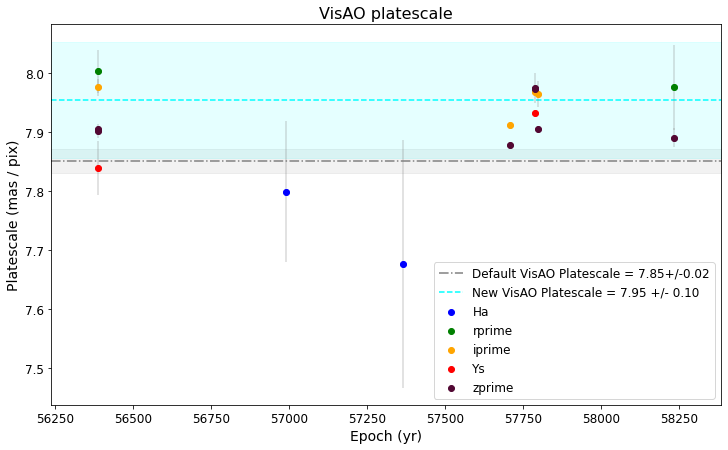

In [48]:
from astropy.time import Time
colors = ['blue', 'green', 'orange', 'red', '#520833']
c = 0
plt.figure(figsize=(12,7))
for wavel in filtdict.keys():
    filt = filtdict[wavel]
    clor = colors[c]
    filtname = filterlist[c]
    c += 1
    platescalelist = []
    platescalelisterr = []
    nights = []
    for night in filt.keys():
        expvals = expdict[night]
        vals = filt[night]
        sep = vals[0]
        seperr = vals[1]
        nights.append(night)
        platescale = expvals['sep']/sep
        platescalelist.append(platescale.to_list()[0])
        platescale_err = platescale*np.sqrt(((seperr/sep)**2)+((expvals['seperr']/expvals['sep'])**2))
        platescalelisterr.append(platescale_err.to_list()[0])
    print(nights)
    print(platescalelist)
    plt.errorbar(nights, platescalelist, yerr=platescalelisterr, color=clor, ecolor='grey', linestyle='', fmt='o', alpha=0.3, zorder=2)
    plt.scatter(nights, platescalelist, color=clor, label=filtname, zorder=3)

x0, x1 = outtable['epoch'][0]-150, outtable['epoch'][8]+150
xar = np.array([x0,x1])
plt.fill_between(xar, np.zeros_like(xar)+7.8513-0.02, np.zeros_like(xar)+7.8513+0.02, color='grey', alpha=0.1, zorder=0)
plt.plot(xar, np.zeros_like(xar)+7.8513, label='Default VisAO Platescale = 7.85+/-0.02', linestyle='dashdot', color='grey', zorder=1)
newplatelabl = 'New VisAO Platescale = '+str(round(newplate,2))+' +/- '+str(round(newplate_err,2))+'0'
plt.fill_between(xar, np.zeros_like(xar)+newplate-newplate_err, np.zeros_like(xar)+newplate+newplate_err, color='#00FFFF', alpha=0.1, zorder=0)
plt.plot(xar, np.zeros_like(xar)+newplate, label=newplatelabl, linestyle='dashed', color='#00FFFF', zorder=1)
plt.legend(loc='lower right')
plt.xlim(x0, x1)
plt.title('VisAO platescale')
plt.xlabel('Epoch (yr)')
plt.ylabel('Platescale (mas / pix)')
plt.savefig('platescale_across epoch.png', dpi=300)

# minimize residuals to linear regression (outdated)

[[0.812      2.62425339 0.22886152]]


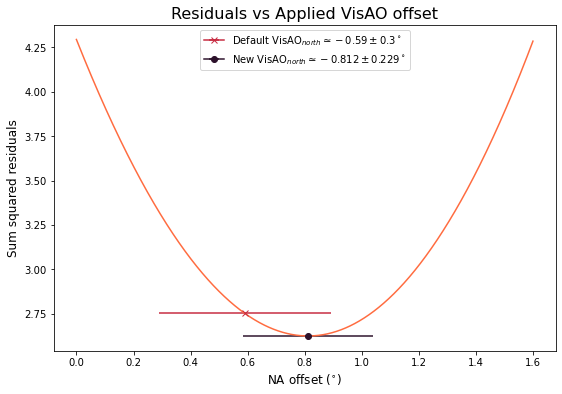

In [59]:
# 
# import numpy as np
# from scipy.odr import *
# # slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
# residuals = []
# for i in np.arange(0, 1.6, 0.001):
#     visP_new = visP-i
#     kekP_orig = nircast['pa']
#     kekPe_orig = nircast['pa_err']
#     allP = np.append(visP_new, kekP_orig)
#     allerr = np.append(visPe, kekPe_orig)
#     allyr = np.append(epochs_yr, epochs_yr_nirc)
    
#     # linear regression accounting for errorbars on y
#     x = allyr
#     y = allP
#     y_err = allerr
    
#     # Define a function to fit the data with.
#     def lin_func(p, x):
#         m, b = p
#         return m*x + b

#     # Create a model for fitting.
#     lin_model = Model(lin_func)

#     # Create a RealData object using our initiated data from above.
#     data = RealData(x, y, sy=y_err)

#     # Set up ODR with the model and data.
#     odr = ODR(data, lin_model, beta0=[0., 1.])

#     # Run the regression.
#     out = odr.run()
    
#     x_fit = np.linspace(x.min(), x.max(), 1000)
#     y_fit = lin_func(out.beta, x_fit)
#     points_y_fit = lin_func(out.beta, epochs_yr)
#     visresid = visP_new-points_y_fit
#     from statsmodels.stats.weightstats import DescrStatsW
#     wstats = DescrStatsW(visresid, 1/visPe, ddof=0)
#     best_fit_err = wstats.std

#     # Use the in-built pprint method to give us results.
#     residuals.append((i, out.sum_square, best_fit_err))    
        
# pa_resid_arr = np.array(residuals)
# best_pa_off = pa_resid_arr[pa_resid_arr[:,1] == pa_resid_arr[:,1].min()]
# print(best_pa_off)
# orig_pa_off = pa_resid_arr[pa_resid_arr[:,0] == 0.59]
# plt.figure(figsize=(9,6))
# plt.plot(pa_resid_arr[:,0], pa_resid_arr[:,1], color='#ff6c40')
# plt.errorbar(orig_pa_off[:,0][0], orig_pa_off[:,1][0], xerr=visao_pa_default_err, marker='x', label='Default VisAO$_{north}\simeq-0.59\pm0.3^\circ$', color='#c72a40')
# newlabel = 'New VisAO$_{north}\simeq-'+str(best_pa_off[0][0])+'\pm'+str(round(best_pa_off[0][2],3))+'^\circ$'
# plt.errorbar(best_pa_off[:,0][0], best_pa_off[:,1][0], xerr=best_fit_err, marker='o', label=newlabel, color='#2c112b')
# plt.title('Residuals vs Applied VisAO offset')#, fontsize=22)
# plt.legend()
# plt.xlabel(r'NA offset ($^{\circ}$)')#, fontsize=18)
# plt.ylabel('Sum squared residuals')#, fontsize=18)
# plt.savefig('NAoff_resids.png', dpi=300)

# epoch to epoch offsets (outdated)

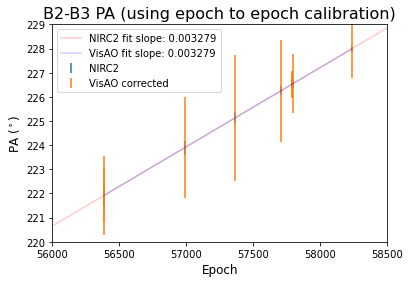

In [63]:
# compare using epoch to epoch offsets
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], kekP)
plt.errorbar(outtable['epoch'], kekP, yerr=kekPe, ls='none', label='NIRC2')
label = 'NIRC2 fit slope: '+str(round(slope,6))
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], 'r', alpha=0.2, label=label)

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa_expected'])
plt.errorbar(outtable['epoch'], outtable['pa_expected'], yerr=outtable['pa_err_expected'], ls='none', label='VisAO corrected')
label = 'VisAO fit slope: '+str(round(slope,6))
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'b', alpha=0.2, label=label)

plt.legend()
plt.xlim(56000, 58500)
plt.ylim(220,229)
plt.title(r'B2-B3 PA (using epoch to epoch calibration)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare_ep2ep.png', dpi=300)

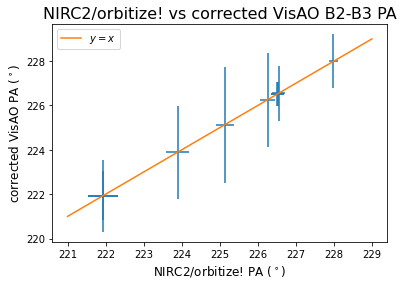

In [64]:
plt.errorbar(x=kekP, y=outtable['pa_expected'], xerr=kekPe, yerr=outtable['pa_err_expected'], ls='none')
plt.plot([221,229],[221,229], label=r'$y=x$')
plt.title('NIRC2/orbitize! vs corrected VisAO B2-B3 PA')
plt.legend()
plt.xlabel(r'NIRC2/orbitize! PA ($^\circ$)')
plt.ylabel(r'corrected VisAO PA ($^\circ$)')
plt.savefig('visao_pa_compare_corrected.png', dpi=300)